In [20]:
%matplotlib notebook

import numpy              as np
import matplotlib.pyplot  as plt
from scipy.interpolate    import interp1d
from scipy                import integrate
from scipy                import signal
from astropy.io           import fits
from scipy                import stats
from scipy                import optimize


<IPython.core.display.Javascript object>


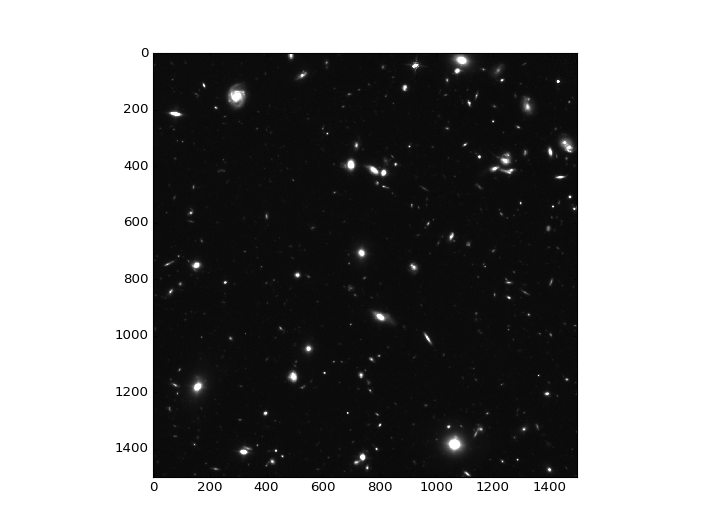

In [63]:
nbins_min = 1500
pixels_with_noise = fits.open('/home/maryhallow/Desktop/python/Reionizatoin/Reion/hlsp_hlf_hst_wfc3-60mas_goodss'
                              '_f160w_v1.0_sci.fits')[0].data[13200:13200+nbins_min,9700:9700+nbins_min]

plt.figure(1)
plt.imshow(pixels_with_noise[::-1,:],interpolation='nearest',vmax=np.max(pixels_with_noise)/99.5,cmap=plt.cm.gray)

In [5]:
data_array = np.reshape(pixels_with_noise,(nbins_min*nbins_min,))
pdf = stats.gaussian_kde(data_array)           # building probability density function

grid_points_x = np.concatenate([np.linspace(np.min(data_array),0.03,500),np.linspace(0.03,1,1000)[1:]])
grid_points_pdf = pdf.evaluate(grid_points_x)

grid_points_cdf = np.zeros_like(grid_points_x) # building culumative density function
for i in range(0,len(grid_points_x)):
    for j in range(1,i+1):
        grid_points_cdf[i] += (grid_points_x[j]-grid_points_x[j-1])*grid_points_pdf[j]

<IPython.core.display.Javascript object>


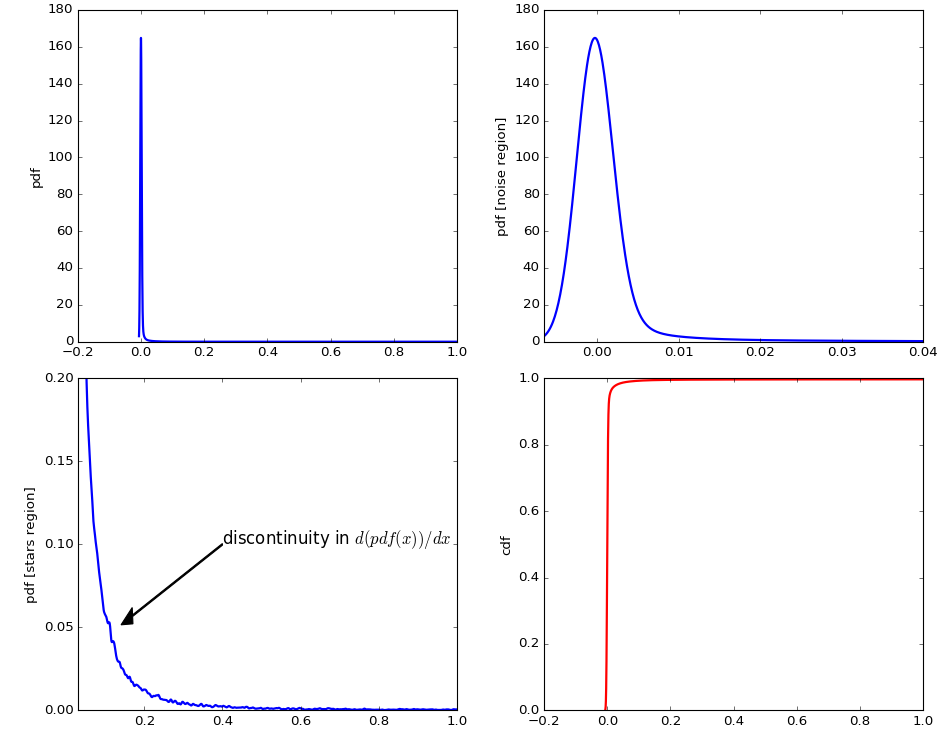

In [89]:
plt.figure(2)

plt.subplot(2,2,1)
plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
plt.plot(grid_points_x,grid_points_pdf,lw=2.)
plt.ylabel('pdf')

plt.subplot(2,2,2)
plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
plt.plot(grid_points_x,grid_points_pdf,lw=2.)
plt.xticks(np.array([0.0,0.01,0.02,0.03,0.04]))
plt.xlim(np.min(data_array),0.04)
plt.ylabel('pdf [noise region]')

plt.subplot(2,2,3)
plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
plt.plot(grid_points_x,grid_points_pdf,lw=2.)
plt.arrow(0.4 , 0.1,-0.23, -0.043, head_width=0.01, head_length=0.03, fc='k', ec='k')
plt.text(0.4,0.1,'discontinuity in $d(pdf(x))/dx$', fontsize=15)
plt.xlim(0.03,1)
plt.ylim(0,0.2)
plt.ylabel('pdf [stars region]')

plt.subplot(2,2,4)
plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
plt.plot(grid_points_x,grid_points_cdf,c='r',lw=2.)
plt.ylabel('cdf')



In [54]:
def f(x,a,b):
    return stats.norm.pdf(x,a,b)

# fitting procedure
popt, pcov = optimize.curve_fit(f,grid_points_x[:500],grid_points_pdf[:500],bounds=([-0.01,0.0], [0.01, 0.01]))
print(popt)

[-0.00020175  0.00239516]


<IPython.core.display.Javascript object>


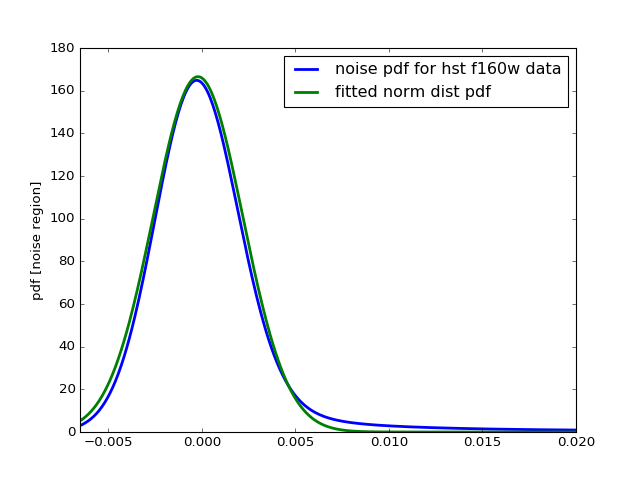

In [96]:
plt.figure(3)
plt.plot(grid_points_x,grid_points_pdf,lw=2.5,label='noise pdf for hst f160w data')
plt.plot(grid_points_x,f(grid_points_x,popt[0],popt[1]),lw=2.5,label='fitted norm dist pdf')
plt.xlim(np.min(data_array),0.02) 
plt.legend(loc='upper right')
plt.ylabel('pdf [noise region]')

max value =  0.00742508111581
mean value =  -0.00245503366669
std =  0.00321450170232


CTYPE1  ='RA---TAN'                                                              [astropy.io.fits.card]
CTYPE2  ='DEC--TAN'                                                              [astropy.io.fits.card]
DATE-OBS='2009-12-13'                                                            [astropy.io.fits.card]
TIME-OBS='21:23:07'                                                              [astropy.io.fits.card]
ROOTNAME='ibcj03kdq                                                              [astropy.io.fits.card]
TARGNAME='OMEGACEN                                                               [astropy.io.fits.card]
FILTER1 =                                                                        [astropy.io.fits.card]
FILTER2 =                                                                        [astropy.io.fits.card]


<IPython.core.display.Javascript object>


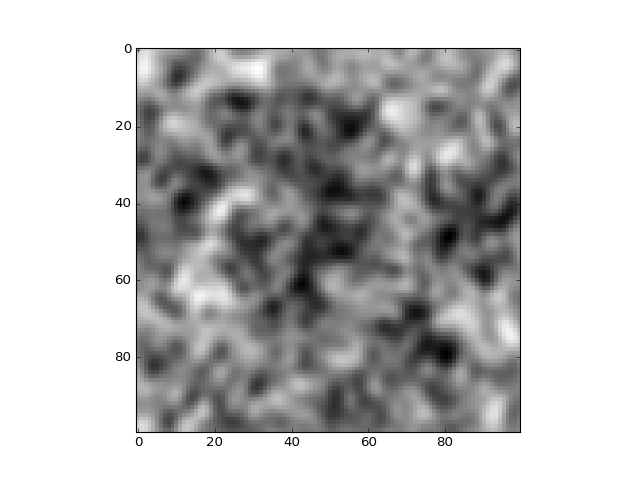

In [94]:
# now let's make use of just built probability density fucntion of normal distribution and create the noise data 
nbins_min = 100
noise = stats.norm.rvs(popt[0],popt[1],nbins_min*nbins_min)
noise = np.reshape(noise,(nbins_min,nbins_min))
PSF = fits.open('psf_wfc3ir_f160w.fits')[0].data
noise = signal.fftconvolve(noise, PSF, mode='same')

print('max value = ',np.max(noise))
print('mean value = ',np.mean(noise))
print('std = ',np.std(noise))

plt.figure(4)
plt.imshow(noise, interpolation='nearest',cmap=plt.cm.gray)